# InsightFace for RGB Data

In [1]:
import insightface
from insightface.app.common import Face
from insightface.model_zoo import model_zoo
import os
# REQUIRED FOR CUDA TO BE USED
import torch

num_subjects = 19
BASE_DIR = os.getcwd()

det_model_path = os.path.join(BASE_DIR, "../models", "buffalo_l", "det_10g.onnx")
rec_model_path = os.path.join(BASE_DIR, "../models", "buffalo_l", "w600k_r50.onnx")

det_model = model_zoo.get_model(det_model_path)
rec_model = model_zoo.get_model(rec_model_path)

det_model.prepare(ctx_id=0, input_size=(480, 640), det_thres=0.5)

Applied providers: ['CUDAExecutionProvider', 'CPUExecutionProvider'], with options: {'CUDAExecutionProvider': {'do_copy_in_default_stream': '1', 'cudnn_conv_algo_search': 'EXHAUSTIVE', 'device_id': '0', 'gpu_external_alloc': '0', 'enable_cuda_graph': '0', 'gpu_mem_limit': '18446744073709551615', 'gpu_external_free': '0', 'gpu_external_empty_cache': '0', 'arena_extend_strategy': 'kNextPowerOfTwo', 'cudnn_conv_use_max_workspace': '1', 'cudnn_conv1d_pad_to_nc1d': '0', 'tunable_op_enable': '0', 'tunable_op_tuning_enable': '0', 'enable_skip_layer_norm_strict_mode': '0'}, 'CPUExecutionProvider': {}}
Applied providers: ['CUDAExecutionProvider', 'CPUExecutionProvider'], with options: {'CUDAExecutionProvider': {'do_copy_in_default_stream': '1', 'cudnn_conv_algo_search': 'EXHAUSTIVE', 'device_id': '0', 'gpu_external_alloc': '0', 'enable_cuda_graph': '0', 'gpu_mem_limit': '18446744073709551615', 'gpu_external_free': '0', 'gpu_external_empty_cache': '0', 'arena_extend_strategy': 'kNextPowerOfTwo',

## Embedding

In [4]:
from glob import glob
import numpy as np
from tqdm import tqdm
from utils import by_experiment
import json

def process_images(path, subjects=[0]):
    undetected = []

    for subject in subjects:
        embs_subject_path = f"data/RGB/embs_{subject}.npy"
        if not os.path.exists(embs_subject_path):
            subject_embeddings = []
            print(f"Subject: {subject}")

            for img_path in tqdm(sorted(glob(rf"{path}\{subject}\*_colour.npy"), key=by_experiment)):
                for i, img in enumerate(np.load(img_path).astype(np.float32)):
                    # Reformat to BGR for OpenCV
                    img = img[..., ::-1]
                    bboxes, kpss = det_model.detect(img, max_num=0, metric="default")
                    # If no face detected, log and add dummy embedding with np.infs
                    if len(bboxes) != 1:
                        undetected.append((img_path.split('\\')[-1], i))
                        subject_embeddings.append(np.zeros((512)) + np.inf)
                        continue
                    face = Face(bbox=bboxes[0, :4], kps=kpss[0], det_score=bboxes[0, 4])
                    rec_model.get(img, face)
                    subject_embeddings.append(face.normed_embedding)

            subject_embeddings = np.stack(subject_embeddings, axis=0)
            print(subject_embeddings.shape)
            np.save(embs_subject_path, subject_embeddings)
    
    if len(undetected) > 0:
        with open('data/RGB/undetected.json', 'w', encoding='utf-8') as f:
            json.dump(undetected, f, ensure_ascii=False, indent=4)

def load_embeddings(path, subjects=[0]):
    labels, unseen_labels = [], []
    embeddings, unseen_embeddings = [], []
    for subject in subjects:
        embs_path = f"{path}/embs_{subject}.npy"
        if os.path.exists(embs_path):
            subject_embeddings = np.load(embs_path)
            h = len(subject_embeddings)//2
            embeddings.append(subject_embeddings[:h])
            unseen_embeddings.append(subject_embeddings[h:])
            labels += [subject]*len(subject_embeddings[:h])
            unseen_labels += [subject]*len(subject_embeddings[h:])

    embeddings = np.concatenate(embeddings, axis=0)
    unseen_embeddings = np.concatenate(unseen_embeddings, axis=0)

    print(embeddings.shape)
    print(unseen_embeddings.shape)
    print(len(labels))
    print(len(unseen_labels))
    return labels, embeddings, unseen_labels, unseen_embeddings

DATA_DIR = os.path.relpath(f"../../Soli/soli_realsense/data")
subjects = range(num_subjects)
process_images(DATA_DIR, subjects)
labels, embeddings, unseen_labels, unseen_embeddings = load_embeddings("data/RGB", subjects)

Subject: 2


  0%|          | 0/15 [00:00<?, ?it/s]

100%|██████████| 15/15 [00:06<00:00,  2.44it/s]

(150, 512)
(1200, 512)
(1200, 512)
1200
1200


## Prediction

In [5]:
from collections import defaultdict

def search_flatten(embeddings, labels, unseen_embeddings, threshold=0.5):
    pred_names = []
    for emb in unseen_embeddings:
        scores = np.dot(emb, embeddings.T)
        scores = np.clip(scores, 0., 1.)

        idx = np.argmax(scores)
        if scores[idx] > threshold:
            pred_names.append(labels[idx])
        else:
            pred_names.append(None)
    
    return pred_names

def get_averages(labels, scores):
    d = defaultdict(list)
    for l, s in zip(labels, scores):
        d[l].append(s)
    
    return {n:np.mean(s) for n, s in d.items()}

def search_average(embeddings, labels, unseen_embeddings, threshold=0.5):
    pred_names = []
    for emb in unseen_embeddings:
        scores = np.dot(emb, embeddings.T)
        scores = np.clip(scores, 0., 1.)

        averages = get_averages(labels, scores)
        pred = sorted(averages, key=lambda x: averages[x], reverse=True)[0]

        if averages[pred] > threshold:
            pred_names.append(pred)
        else:
            pred_names.append(None)
    
    return pred_names

## Evaluation

In [6]:
from sklearn.metrics import confusion_matrix

def evaluate(true_labels, pred_labels, classes):
    coverage = np.mean([n is not None for n in pred_labels]) * 100.

    is_corrects = [t == p for t, p in zip(true_labels, pred_labels) if p]
    if not is_corrects:
        is_corrects.append(False)

    accuracy = np.mean(is_corrects) * 100.

    prec_cm = confusion_matrix(true_labels, pred_labels)

    return accuracy, coverage, prec_cm

[Text(0.5, 47.7222222222222, 'Predictions'),
 Text(120.72222222222221, 0.5, 'Actual'),
 Text(0.5, 1.0, 'Precision Confusion Matrix')]

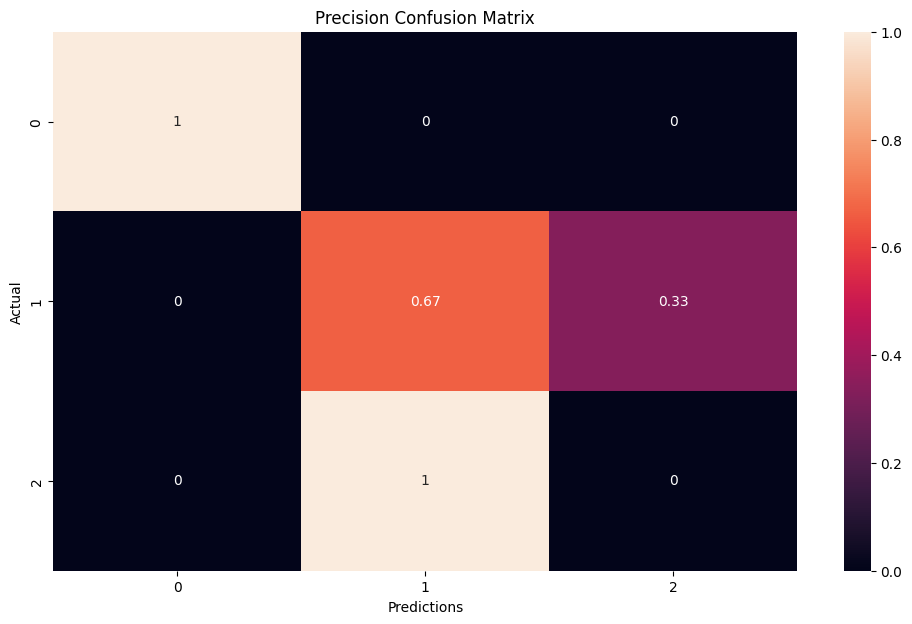

In [11]:

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

gt = [1,1,2,2,1,0]
p = [1,1,1,1,2,0]

cm = confusion_matrix(gt, p)
df_cm = pd.DataFrame(cm / np.sum(cm, axis=1)[:, None])
plt.figure(figsize = (12,7))
# plt.xlabel("Prediction")
# plt.ylabel("Actual")
gfg = sn.heatmap(df_cm, annot=True)
gfg.set(xlabel ="Predictions", ylabel = "Actual", title ='Precision Confusion Matrix')

### Accuracy and Coverage

In [7]:
import pandas as pd

pred_names = search_flatten(embeddings, labels, unseen_embeddings, threshold=0)
acc_flatten, cov_flatten = evaluate(unseen_labels, pred_names)

pred_names = search_average(embeddings, labels, unseen_embeddings, threshold=0)
acc_average, cov_average = evaluate(unseen_labels, pred_names)

# TODO: ALSO ACCOUNT FOR FAILURES -> UNDETECTED FACES ETC.
results = pd.DataFrame([
    {'method': 'flatten', 'accuracy': acc_flatten, 'coverage': cov_flatten},
    {'method': 'average', 'accuracy': acc_average, 'coverage': cov_average},
])

results

,method,accuracy,coverage
0,flatten,100.0,98.333333
1,average,100.0,95.583333


# Analysing Best Threshold

In [ ]:
import matplotlib.pyplot as plt

thresholds = np.arange(0, 1, 0.05)
accuracies = []
coverages = []
for t in thresholds:
    # BEST PERFORMING IS FLATTEN
    pred_names = search_flatten(embeddings, labels, unseen_embeddings, t)
    # pred_names = search_average(known_embeddings, known_names, unknown_embeddings, t)
    acc, cov = evaluate(unseen_labels, pred_names)
    accuracies.append(acc)
    coverages.append(cov)

plt.plot(thresholds, accuracies)
plt.plot(thresholds, coverages)
plt.show()